<a href="https://colab.research.google.com/github/llcorrea/gradient_descent/blob/main/Gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementation of the method of Gradient Descent**

This code implements a Gradient Descent (GD) from scratch in order to minimize a loss function through a linear regression problem.

However, Gradient Descent can be employed in different ML algorithms and scenarios. 

Basically, the algorithm is used in the ML training step to find, as an optimization process, a set of weights and biases that have low loss, on average, across the entire training dataset.

To demonstrate the usage of the GD and its applicability to a linear regression problem, we are going to explore the dataset of *Marketing and Sales* from Kaggle, which contains information about TV, influencer, radio, and social media ads budget related to sales.

Dataset from Kaggle:
https://www.kaggle.com/harrimansaragih/dummy-advertising-and-sales-data

In [ ]:
import sys
import io
import pdb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from google.colab import files
import re
import math
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# **Loading CSV files into Colab from a local drive**

In [ ]:
try:
  train_data = pd.read_csv('train_sales.csv')
except:
  uploaded = files.upload()
  train_data = pd.read_csv('train_sales.csv')

Saving train_sales.csv to train_sales.csv


# **EDA step**

> **Dataset size:** 4572 entries\
> **Number of features:** 5 features\
> **Target feature:** Sales

* Each entry is a digital seller.

* The target feature (Sales) indicates the amount of money in sales a given seller has earned based on the other features.

**Missing values:**

* **Dataset features:**  
  * TV (10)
  * Radio (4)
  * Social Media (6)
  * Sales (6)

In [ ]:
print(train_data.shape)
print(train_data.head())

#print(train_data.tail())
#print(train_data.columns)
print(train_data.describe())
print(train_data.info())
print(train_data.isnull().sum())

(4572, 5)
     TV      Radio  Social Media Influencer       Sales
0  16.0   6.566231      2.907983       Mega   54.732757
1  13.0   9.237765      2.409567       Mega   46.677897
2  41.0  15.886446      2.913410       Mega  150.177829
3  83.0  30.020028      6.922304       Mega  298.246340
4  15.0   8.437408      1.405998      Micro   56.594181
                TV        Radio  Social Media        Sales
count  4562.000000  4568.000000   4566.000000  4566.000000
mean     54.066857    18.160356      3.323956   192.466602
std      26.125054     9.676958      2.212670    93.133092
min      10.000000     0.000684      0.000031    31.199409
25%      32.000000    10.525957      1.527849   112.322882
50%      53.000000    17.859513      3.055565   189.231172
75%      77.000000    25.649730      4.807558   272.507922
max     100.000000    48.871161     13.981662   364.079751
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572 entries, 0 to 4571
Data columns (total 5 columns):
 #   Column      

# **Correlation between features**

,TV,Radio,Social Media,Sales
TV,1.000000,0.869460,0.528168,0.999497
Radio,0.869460,1.000000,0.607452,0.869105
Social Media,0.528168,0.607452,1.000000,0.528906
Sales,0.999497,0.869105,0.528906,1.000000


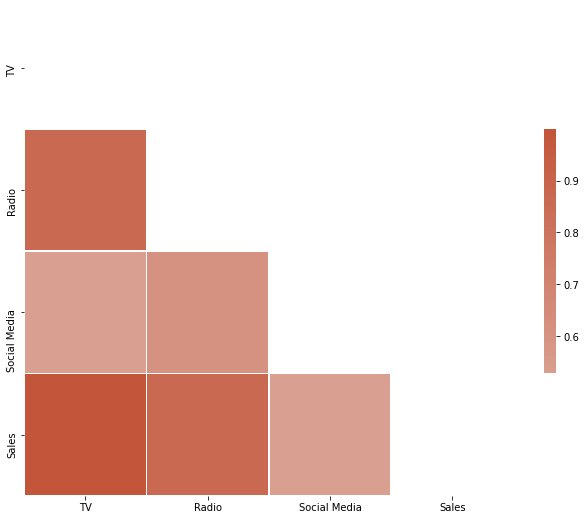

In [ ]:
corr=train_data.iloc[:, :].corr()
display(corr)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **Feature transformation**

In [ ]:
train_data = pd.get_dummies(train_data, drop_first = True)
train_data

,TV,Radio,Social Media,Sales,Influencer_Mega,Influencer_Micro,Influencer_Nano
0,16.0,6.566231,2.907983,54.732757,1,0,0
1,13.0,9.237765,2.409567,46.677897,1,0,0
2,41.0,15.886446,2.913410,150.177829,1,0,0
3,83.0,30.020028,6.922304,298.246340,1,0,0
4,15.0,8.437408,1.405998,56.594181,0,1,0
...,...,...,...,...,...,...,...
4567,26.0,4.472360,0.717090,94.685866,0,1,0
4568,71.0,20.610685,6.545573,249.101915,0,0,1
4569,44.0,19.800072,5.096192,163.631457,0,1,0
4570,71.0,17.534640,1.940873,253.610411,0,0,0


# **Prediction of sales**

As a case study to our model, we are going to *predict the sales* based on a single feature: *the Radio feature*, which presents a reasonable correlation with the target feature but not a total one.

Correlation between Sales and Radio of 0.869.

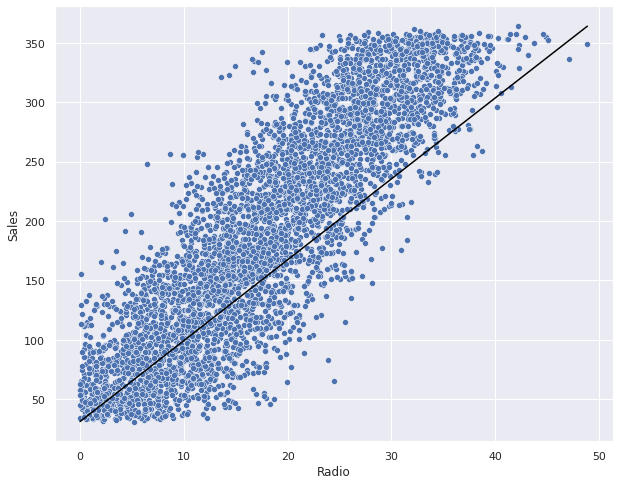

In [ ]:
sns.set()
plt.figure(figsize=(10, 8))
sns.scatterplot(y='Sales', x='Radio', data=train_data)
plt.plot([min(train_data['Radio']), max(train_data['Radio'])], [min(train_data['Sales']), max(train_data['Sales'])], color='black')

# **ML steps**

1. Split of the dataset between train and test.

2. Fit the ML model to the train dataset. In this case, we use a linear regression equation.

3. Predict values through the test dataset.

4. Compute loss and accuracy metrics. The Mean Squared Error (MSE) was adopted.

5. If stop criterion is not satisfied, update parameter values based on the loss function and return to the step 2. The update step of the regression parameters is done through the Gradient Descent algorithm.

* Stop criterion: Iterate till overall loss stops changing or at least changes extremely slowly (convergence of the model).

**Treat Missing Data**

Drop the entries with missing data.

In [ ]:
train_data=train_data.dropna(axis=0)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4546 entries, 0 to 4571
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TV                4546 non-null   float64
 1   Radio             4546 non-null   float64
 2   Social Media      4546 non-null   float64
 3   Sales             4546 non-null   float64
 4   Influencer_Mega   4546 non-null   uint8  
 5   Influencer_Micro  4546 non-null   uint8  
 6   Influencer_Nano   4546 non-null   uint8  
dtypes: float64(4), uint8(3)
memory usage: 190.9 KB


In [ ]:
X = train_data['Radio']
y = train_data['Sales']
display(X.head())
display(y.head())

0     6.566231
1     9.237765
2    15.886446
3    30.020028
4     8.437408
Name: Radio, dtype: float64

0     54.732757
1     46.677897
2    150.177829
3    298.246340
4     56.594181
Name: Sales, dtype: float64

**Data split between train and validation datasets**

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=376) #test_size=0.3, 0.2
print(train_X.head())
print(train_y.head())

1650     2.181142
4435    11.533551
3384    16.876230
516      9.100429
172     23.434787
Name: Radio, dtype: float64
1650     56.189924
4435    148.130044
3384    108.852312
516     147.593573
172     288.020745
Name: Sales, dtype: float64


# **Implementation of the Linear Regression and Gradient Descent**

Linear regression is a statistical algorithm used to model the relationship between a dependent variable (target) with a set of independent variables (features).

Simple linear regression is used to infer the behavior of a target by using a single feature. It is assumed that the two variables are linearly related. 

**The algorithm implements a linear function to predict the target $(y')$ as a function of the feature $(x)$.**

**Based on our dataset previously described, the independent variable $x$ is the feature *Radio* and the target $y$ is the *Sales*.**



### **Linear regression equation:**

The model tries to find a regression line that better represent the relationship between our variables (independent and dependent ones), so that it's possible to predict the target for any new data.  

This line is modeled by the linear regression equation:

> $y' = b + mx$
>
> Where $b$ means the y-intercept parameter, which represents the value of $y'$ when $x$ is equal to 0.
>
> The parameter $m$ is the slope of the line (a.k.a. weight of variable $x$ in ML algorithms).
>
> Based on the linear regression equation parameters, we can say that the value of $y'$ (dependent variable of $x$) will be increased in $m$ times at each amount of increasement of the variable $x$. Considering that the initial value of $y'$ when $x=0$ is $b$.

To fit our model to the data, the parameters (regression coefficients) of the linear equation ($b$ and $m$) must be adjusted or estimated. 

To do so, the predicted results from the regression equation are evaluated with a loss function. 

In an iterative cycle, the parameters of the model are modified and re-evaluated in order to reduce the error, i.e., minimize the loss function towards the minimum of the function. 

This update or optimization of parameters can be done in an efficient way through the Gradient Descent algorithm.

After the optimization of the parameters, we can use the model to predict target values based on new values of the independent variable.


### **Gradient Descent algorithm:**

The GD algorithm is an optimizer used to minimize the loss function. It takes parameters and tunes them till the local minimum is reached.

* Requirements of the GD:
  1. Definition of the minimization function. In our case, we use the MSE as loss function.

  2. Definition of parameters to be minimized. The parameters of the regression function are the $m$ and $b$.

  3. Calculation of the partial derivatives of MSE with respect to these parameters. The derivative of each parameter is used to tune it, giving the direction and magnitude to minimize the function.

* Steps of the GD:
  1. Assign starting values for the parameters (*b* and *m*).

  2. Computation of the gradient of the loss curve at the starting points.

  3. Iterative update of parameters via the partial derived functions (gradient) in order to minimize the MSE. Use of the learning rate parameter which defines the step size of the parameter movement at each iteration.\
    *It is important the simultaneously update of parameters.*

* The gradient in convex landscapes is equal to the derivative (slope) of the curve. When there are multiple parameters, the gradient is a vector of partial derivatives with respect to the parameters.

### **Loss equation:**

The loss related to the fit of the model is the error (difference) between the predicted value (y') and the observed one (y). 

One of the most common metrics used in ML to score the error is the Mean Squared Error (MSE).

>**Mean squared error:**
>
>$MSE = \frac{1}{2N}\sum_{i=1}^{N}(y'_i - y_i)^2$
>
>Where $y' = b +mx$



In [ ]:
def MSE_function(predicted, y):
  MSE=sum(((predicted - y)**2))
  MSE/=(2*len(y))
  return MSE

### **Partial derivatives:**

Partial derivatives describe how much each parameter individually changes the function when it is pertubed.

The derivatives are calculated separately with respect to the parameters (*m* and *b*) of the function to be minimzed. 

Re-writing the MSE equation as function *f(m, b)* with two parameters:

>$f(b, m) = \frac{1}{2N}\sum_{i=1}^{N}((b + mx_i) - y_i)^2$

With this, we compute the partial derivative of *f* for each parameter.

#### **Partial first order derivative of *f* with respect to *b* ($\frac{\partial f}{\partial b}$):**

The partial derivative of *f* w.r.t. *b*, denoted as $\frac{\partial f}{\partial b}$, is the derivative of *f* considered as a function of *b* alone. 

Basically, we derive the parameter *b* of *f*, whereas parameter *m* remains constant, i.e., *m* and anything that is not *b* can be treated as constants (equal to 0). To find $\frac{\partial f}{\partial b}$, we must to hold *m* constant and take the regular derivative of *f* w.r.t. *b*.

Thus, we have the following partial derivative:

> $\frac{\partial f}{\partial b} = \frac{1}{N}\sum_{i=1}^{N} ((b + mx_i ) - y_i)$

#### **Partial first order derivative of *f* with respect to *m* ($\frac{\partial f}{\partial m}$):** 

The same rationale explained above is used to derive parameter *m*. Parameter *b* is treated as a constant (equal to 0).
Then, we have the following partial derivative of *f* w.r.t. *m*:

> $\frac{\partial f}{\partial m} = \frac{1}{N}\sum_{i=1}^{N} (((b + mx_i) - y_i)x_i)$


# **Gradient Descent algorithm for parameters *b* and *m***

* Firstly, we start defining random values for $m$ and $b$. 

* Then, the iteration process at each generation compute the gradient descent vector for parameters through the derived functions previously described. The gradient vector of function $f$ ($\nabla f$) is the vector of partial derivatives w.r.t. all of the parameters in $f$. Thus, for each parameter we will have one gradient:

> $\nabla f(b, m) = (\frac{\partial f}{\partial b}, \frac{\partial f}{\partial m})$

* The gradient is a value with direction and magnitude: 
  * $\nabla f$ points to the direction of the greatest increase of the function (maximum local). $\nabla f$ always points to the steepest increase of $f$.

  * $- \nabla f$ points to the oppsosite direction. It points to the greatest decrease of $f$ (minimum local). **With this, the gradient descent $- \nabla f$ is used to minimize the loss function and optimize the parameters of the model.**

* The GD algorithm takes a step in direction of the negative gradient ($- \nabla f$) to reduce the loss of the model.

* The new values for parameters are defined based on the current values added to the negative gradients multiplied by the learning rate, which gives the step size of modification:

> $b = b - \alpha \cdot \frac{\partial f}{\partial b}$
>
> $m = m - \alpha \cdot \frac{\partial f}{\partial m}$

In [ ]:
def gradient_descent(X, y, l_rate=0.001, n_gen=1000):
  #X=np.array([1, 2, 4, 3, 5])
  #y=np.array([1, 3, 4, 2, 5])

  #l_rate = learning rate
  #n_gen = number of generations to fit the regression

  ##parameters of the linear regression equation
  m=0.0
  b=0.0
  print('initial params - b: %f / m: %f' % (b, m))

  err=[] #acc MSE
  params=[]
  for gen in range(n_gen):
    ##fit the model using the regression equation
    predictions=(b + m*X)

    ##MSE
    #mean_squared_error(train_y, predictions) #sklearn implementation 
    err.append(MSE_function(predictions, y))
    params.append((b, m))
    print('iter:', gen, 'loss:', err[-1])

    ##update parameters via Gradient Descent
    f = (predictions - y)
    #derivative of MSE in function of b
    gradient_b = sum(f)/len(y)
    #derivative of MSE in function of m
    gradient_m = sum((X*f))/len(y)
    #simultaneously update parameters
    temp_b = b - l_rate * gradient_b
    temp_m = m - l_rate * gradient_m
    b, m = temp_b, temp_m
    print('new params - b: %f / m: %f' % (b, m))
  
  plt.figure(figsize=(10, 8))
  plt.scatter(X, y, c='red')
  plt.scatter(X, predictions, c='darkblue')
  plt.plot([min(X), max(X)], [min(predictions), max(predictions)], color='black', label='Regression line')
  plt.title('Observed vs Predicted values (Training step)')
  plt.xlabel('X-variable')
  plt.ylabel('y-target')
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 8))
  plt.plot(range(1, len(err)+1), err, c='black', linewidth=2.0)
  plt.title('Loss curve')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.show()

  print('Training | R2 score:', r2_score(y, predictions)) #R2
  return b, m, err

def simple_validation(X, y, b, m):
  #validation function of the simple linear regression
  predictions=(b + m*X)

  print('Validation | MSE: ', MSE_function(predictions, y))
  print('Validation | R2 score:', r2_score(y, predictions)) #R2

  plt.figure(figsize=(10, 8))
  plt.scatter(X, y, c='red')
  plt.scatter(X, predictions, c='darkblue')
  plt.plot([min(X), max(X)], [min(predictions), max(predictions)], color='black', label='Regression line')
  plt.title('Observed vs Predicted values (Validation step)')
  plt.xlabel('X-variable')
  plt.ylabel('y-target')
  plt.legend()
  plt.show()

initial params - b: 0.000000 / m: 0.000000
iter: 0 loss: 22952.197916853547
new params - b: 0.192998 / m: 4.295554
iter: 1 loss: 8396.31388612799
new params - b: 0.307762 / m: 6.763358
iter: 2 loss: 3591.4114048988963
new params - b: 0.377576 / m: 8.181044
iter: 3 loss: 2005.2740364939714
new params - b: 0.421565 / m: 8.995396
iter: 4 loss: 1481.6398592731675
new params - b: 0.450714 / m: 9.463108
iter: 5 loss: 1308.7343140438918
new params - b: 0.471337 / m: 9.731661
iter: 6 loss: 1251.6030949097699
new params - b: 0.487061 / m: 9.885790
iter: 7 loss: 1232.6886028367508
new params - b: 0.499968 / m: 9.974178
iter: 8 loss: 1226.3893441781702
new params - b: 0.511257 / m: 10.024794
iter: 9 loss: 1224.2543549321142
new params - b: 0.521615 / m: 10.053709
iter: 10 loss: 1223.4940012695572
new params - b: 0.531437 / m: 10.070157
iter: 11 loss: 1223.1874347570438
new params - b: 0.540950 / m: 10.079441
iter: 12 loss: 1223.0306865191264
new params - b: 0.550286 / m: 10.084609
iter: 13 loss: 

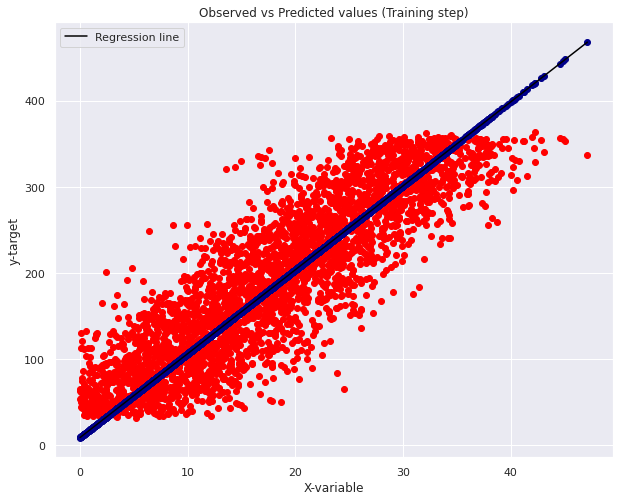

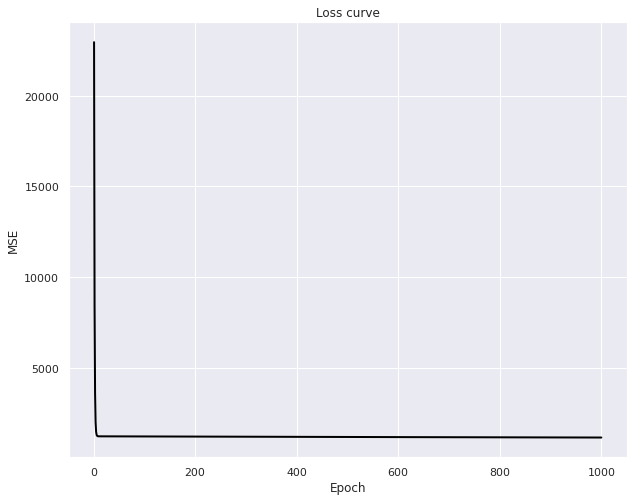

Training | R2 score: 0.7327356669556422
Validation | MSE:  1216.3489412764352
Validation | R2 score: 0.7182901910399313


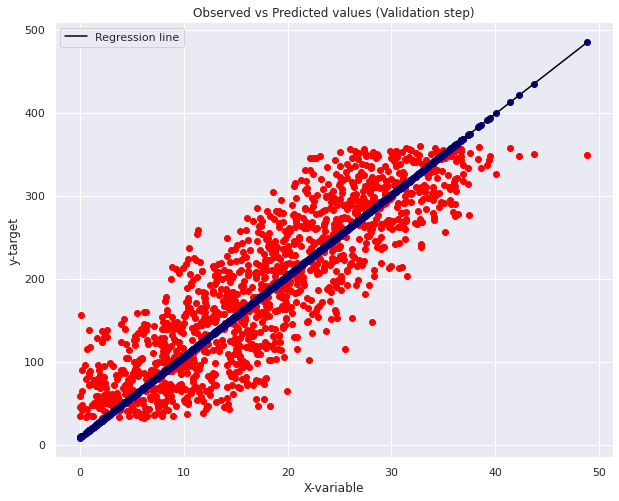

In [ ]:
##training step
b, m, err=gradient_descent(train_X, train_y) #Batch GD
#b, m, err=gradient_descent(train_X[:10], train_y[:10]) #SGD

##validation step
simple_validation(val_X, val_y, b ,m)

# **Linear Regresion method from SkLearn**

In [ ]:
new_X, new_y = train_X.values.reshape(-1, 1), train_y.values.reshape(-1, 1)
reg = LinearRegression().fit(new_X, new_y)
print('Training | R2 score:', reg.score(new_X, new_y)) #R2

new_valX, new_valy = val_X.values.reshape(-1, 1), val_y.values.reshape(-1, 1)
print('Validation | R2 score:', reg.score(new_X, new_y)) #R2

Training | R2 score: 0.7605043516452846
Validation | R2 score: 0.7605043516452846


# **Multivariate Linear Regression**

Multivariate linear regression is used to estimate the behavior of a target feature $(y)$ by using mutiple features $(X^k)$. It is assumed that these variables are linearly related. 

**Thus, the algorithm implements a linear function to predict the target $(y')$ as a function of the featuress $(X)$.**

> $y' = b + m^1x^1 + ... + m^kx^k$
>
> Where $b$ is the y-intercept parameter, and parameter $m_j$ is the weight of the $j^{-th}$ varibale, where $j=[1, ..., k]$. $k$ is the total number of features.

> Rewriting parameter $b$ as $m^0$ and assuming $x^0=1$, we have the following multivariate equation:
>
>$y' = \sum_{i=0}^{k} m^ix^i$

**Based on our dataset previously described, we will adopt as independent variables $X^2$ the features *Radio* and *Social Media*. The target $y$ is given by *Sales*.**

# **Gradient Descent algorithm for (n>2) parameters**

* Firstly, we start defining random values for $\theta$ parameters. 

* Then, the iteration process at each generation compute the gradient descent vector for parameters through the derived functions:

  * Partial first order derivative of *f* with respect to *$\theta^j$* ($\frac{\partial f}{\partial \theta^j}$):

> $\frac{\partial f}{\partial \theta^j} = \frac{1}{N}\sum_{i=1}^{N} ((y'_i - y_i)x_i^j)$

The gradient vector of function $f$ ($\nabla f$) is the vector of partial derivatives w.r.t. all of the parameters in $f$. Thus, for each parameter we will have one gradient:

> $\nabla f(\theta) = (\frac{\partial f}{\partial \theta^j}), j=0, ..., k$

* The new values for $\theta$ parameters are defined based on the current values added to the negative gradients multiplied by the learning rate, which gives the step size of modification:

> $\theta^j = \theta^j - \alpha \cdot \frac{\partial f}{\partial \theta^j}$

* Each $\theta$ parameter is plugged in the multivariate linear regression equation to estimate the target value. 

### **Re-definition of datasets and features for multiple linear regression:**

In [ ]:
X = train_data[['Radio', 'Social Media']]
y = train_data['Sales']

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=376) #test_size=0.3, 0.2
print(train_X.head())
print(train_y.head())

          Radio  Social Media
1650   2.181142      0.316356
4435  11.533551      0.506740
3384  16.876230      1.049501
516    9.100429      2.705530
172   23.434787      5.914866
1650     56.189924
4435    148.130044
3384    108.852312
516     147.593573
172     288.020745
Name: Sales, dtype: float64


In [ ]:
def multiple_gradient_descent(X, y, l_rate=0.001, n_gen=1000):
  #l_rate = learning rate
  #n_gen = number of generations to fit the regression

  rows=X.shape[0]
  cols=X.shape[1]

  ##parameters of the linear regression equation
  params=[0]*(cols+1) #bias and weights
  print('initial params: %s' % str(params))
 
  err=[] #acc MSE
  param_values=[]
  for gen in range(n_gen):
    ##fit the model using the regression equation
    predictions=params[0]*np.ones(rows) #bias
    for j in range(1, len(params)):
      predictions+=params[j]*X.iloc[:, j-1] #weights

    ##MSE
    #mean_squared_error(predictions, train_y) #sklearn implementation 
    err.append(MSE_function(predictions, y))
    param_values.append(params)
    print('iter:', gen, 'loss:', err[-1])

    ##update parameters via Gradient Descent
    f = (predictions - y)
    gradient_p=[] #gradient array
    for j in range(len(params)):
      if j==0: #bias
        gradient_p.append(sum(f)/len(y))
      else:
        gradient_p.append(sum(X.iloc[:, j-1]*f)/len(y))
      params[j]=params[j] - l_rate * gradient_p[j]

    print('new params: %s:' % str(params))

  plt.figure(figsize=(10, 8))
  plt.plot(range(1, len(err)+1), err, c='black', linewidth=2.0)
  plt.title('Loss curve')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.show()

  print('Training | R2 score:', r2_score(y, predictions)) #R2
  return params, err

def multiple_validation(X, y, params):
  #validation function of the multivariate linear regression

  rows=X.shape[0]
  cols=X.shape[1]
  
  predictions=params[0]*np.ones(rows) #bias
  for j in range(1, len(params)):
    predictions+=params[j]*X.iloc[:, j-1] #weights

  print('Validation | MSE: ', MSE_function(predictions, y))
  print('Validation | R2 score:', r2_score(y, predictions)) #R2

initial params: [0, 0, 0]
iter: 0 loss: 22952.197916853547
new params: [0.1929978613907732, 4.295554491549092, 0.7435244162860648]:
iter: 1 loss: 8080.933289698801
new params: [0.30530670544460176, 6.709199573536546, 1.161862786700903]:
iter: 2 loss: 3384.668348759052
new params: [0.37227119489537647, 8.065300823047203, 1.3974596682496143]:
iter: 3 loss: 1901.5762803712107
new params: [0.4137533625905668, 8.827112784973876, 1.5303621861465078]:
iter: 4 loss: 1433.1751671657885
new params: [0.44091473412459964, 9.254962647729503, 1.6055530539318557]:
iter: 5 loss: 1285.204311370639
new params: [0.46002756065827244, 9.495142003092573, 1.64831044072205]:
iter: 6 loss: 1238.4224661984385
new params: [0.474616551881866, 9.629859819754168, 1.6728394916539437]:
iter: 7 loss: 1223.595229516518
new params: [0.48666242885556027, 9.705313656786208, 1.6871228349867782]:
iter: 8 loss: 1218.8590034756132
new params: [0.4972782639008329, 9.747464360714039, 1.6956463381607825]:
iter: 9 loss: 1217.3094

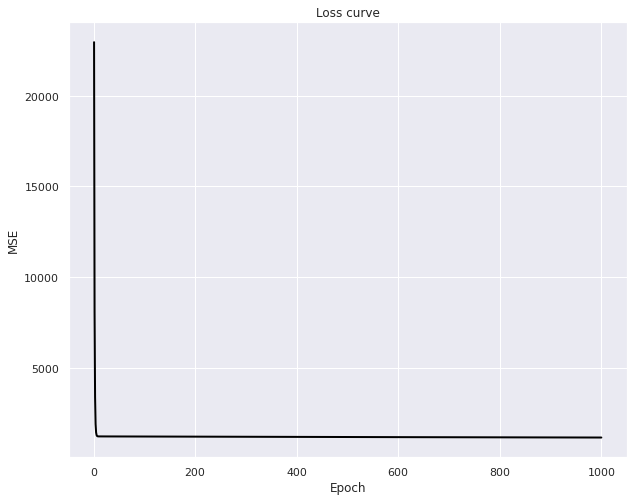

Training | R2 score: 0.7331894596911557
Validation | MSE:  1210.5745130238015
Validation | R2 score: 0.7196275647364927


In [ ]:
##training step
params, err=multiple_gradient_descent(train_X, train_y) #Batch GD
#b, m, err=gradient_descent(train_X[:10], train_y[:10]) #SGD

##validation step
multiple_validation(val_X, val_y, params)

### **Standardization of features:**

Standardization means rescales data to have a mean of 0 and a standard deviation of 1.

This process supports the optimization algorithm to find the global minimum more quickly (accelerated convergence) as the parameters are set in a small range of values.

When applying Gradient Descent in comparison with features without normalization, the learning rate when using standardized features may be higher, and the algorithm may converge faster with better fit. 

In [ ]:
def std_features(train_X, val_X, vars):
  ##standardize features
  std_sca=StandardScaler()
  std_sca.fit(train_X[vars])
  train_X.loc[:, vars]=std_sca.transform(train_X[vars])
  val_X.loc[:, vars]=std_sca.transform(val_X[vars])
  return train_X, val_X

print(train_X.head())
print(train_y.head())

train_X, val_X = std_features(train_X, val_X, ['Radio', 'Social Media'])

print(train_X.head())
print(train_y.head())

         Radio  Social Media
1650 -1.643559     -1.365220
4435 -0.682057     -1.278164
3384 -0.132787     -1.029981
516  -0.932201     -0.272743
172   0.541485      1.194762
1650     56.189924
4435    148.130044
3384    108.852312
516     147.593573
172     288.020745
Name: Sales, dtype: float64
         Radio  Social Media
1650 -1.643559     -1.365220
4435 -0.682057     -1.278164
3384 -0.132787     -1.029981
516  -0.932201     -0.272743
172   0.541485      1.194762
1650     56.189924
4435    148.130044
3384    108.852312
516     147.593573
172     288.020745
Name: Sales, dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/

initial params: [0, 0, 0]
iter: 0 loss: 22952.197916853547
new params: [9.649893069538662, 4.056813402171444, 2.429092687772468]:
iter: 1 loss: 20706.316493489052
new params: [18.81729148560037, 7.837421954361766, 4.6142056561134535]:
iter: 2 loss: 18700.68273951931
new params: [27.526319980859014, 11.363004647126328, 6.575879912028847]:
iter: 3 loss: 16908.4213558154
new params: [35.7998970513547, 14.65306113588938, 8.332989758001943]:
iter: 4 loss: 15305.815646893805
new params: [43.659795268325624, 17.725546046006286, 9.902876846998717]:
iter: 5 loss: 13871.91640994189
new params: [51.126698574448, 20.59699251380365, 11.30147347840138]:
iter: 6 loss: 12588.20177008128
new params: [58.220256715264256, 23.282625826746838, 12.543415997922045]:
iter: 7 loss: 11438.281021364715
new params: [64.95913694903967, 25.79646795666128, 13.642149095326522]:
iter: 8 loss: 10407.636513540072
new params: [71.36107317112634, 28.1514337162618, 14.610021730128526]:
iter: 9 loss: 9483.398462771833
new p

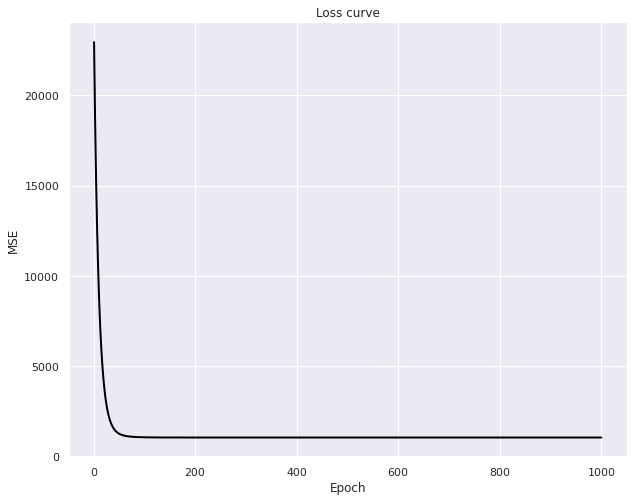

Training | R2 score: 0.7605376991496883
Validation | MSE:  1121.957386011086
Validation | R2 score: 0.740151538634266


In [ ]:
##training step
params, err=multiple_gradient_descent(train_X, train_y, l_rate=0.05) #Batch GD
#b, m, err=gradient_descent(train_X[:10], train_y[:10]) #SGD

##validation step
multiple_validation(val_X, val_y, params)